<a href="https://colab.research.google.com/github/enridagoo/enridagoo-DataScience-GenAI-Submissions/blob/main/Assignment_7/4_01_Decision_Trees_COMPLETED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 4.01 Decision Trees

Following up on our logistic regression example, we will also run an equivalent using _decision trees_.

We'll begin using the inbuilt dataset from scikit-learn we used previously. The dataset is for predicting the presence of breast cancer or not. You can get more details here: [https://scikit-learn.org/1.5/datasets/toy_dataset.html](https://scikit-learn.org/1.5/datasets/toy_dataset.html). The code is the same as in the previous example.

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer

# import the data
data = load_breast_cancer()

# create a DataFrame of features
x_values = pd.DataFrame(data.data, columns=data.feature_names)

from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data
normal_data = scaler.fit_transform(x_values)

# recreate x_values using the scaled data and original feature names
x_values = pd.DataFrame(normal_data, columns=data.feature_names)

# create y value
y_value = pd.DataFrame(data.target, columns=['class'])
y_value = np.ravel(y_value)

## Train-Test split
As before, our next step will be to split the data:

In [2]:
# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=1984, stratify=y_value)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(455, 30)
(114, 30)
(455,)
(114,)


Our code is basically the same as before except with an extra parameter ("stratify=y_value"). This part means we make sure there is a propotionate number of each class in our training data. We want to avoid having minimal examples of one of the classes to learn from (as the split is otherwise fully random).

We can confirm this has worked by looking at the size of our different datasets:


*   `X_train` (the $x$ values we use for training) is 455 rows and 30 columns;
*   `X_test` (the $x$ values we use for testing) is 114 rows and 30 columns;
*   `Y_train` (the $Y$ values we use for training) is 455 rows and a single column;
*   `Y_test` (the $Y$ values we use for testing) is 114 rows and a single columns. All seems to be correct!

## Decision Trees
We'll begin with a standard decision tree model WITHOUT adjusting for any hyperparameters. We first need to specify the model:

In [3]:
from sklearn.tree import DecisionTreeClassifier as DTC

# create the model
DTC_algo = DTC()
DTC_algo

DecisionTreeClassifier()

As before, this is the unfitted/untrained algorithm. Let's make a model:

In [4]:
DTC_model = DTC_algo.fit(X_train, Y_train)
DTC_model

DecisionTreeClassifier()

But how does it perform? I'll give you a metric for free, but you will then have to create some more:

In [5]:
from sklearn.metrics import accuracy_score

# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.94


We have strong performance ... 90% accuracy. However, not as good as Logistic Regression. Let's look at the confusion matrix:

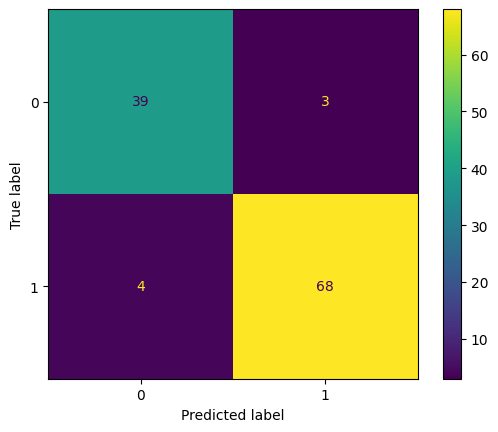

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay as CM

# create a confusion matrix
CM.from_predictions(Y_test, predict)

We can also extract the precision, recall and F1 score:

In [7]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")

Micro-averaged Precision: 0.94
Micro-averaged Recall: 0.94
Micro-averaged F1-score: 0.94


Macro-averaged Precision: 0.93
Macro-averaged Recall: 0.94
Macro-averaged F1-score: 0.93


We can also see our tree:

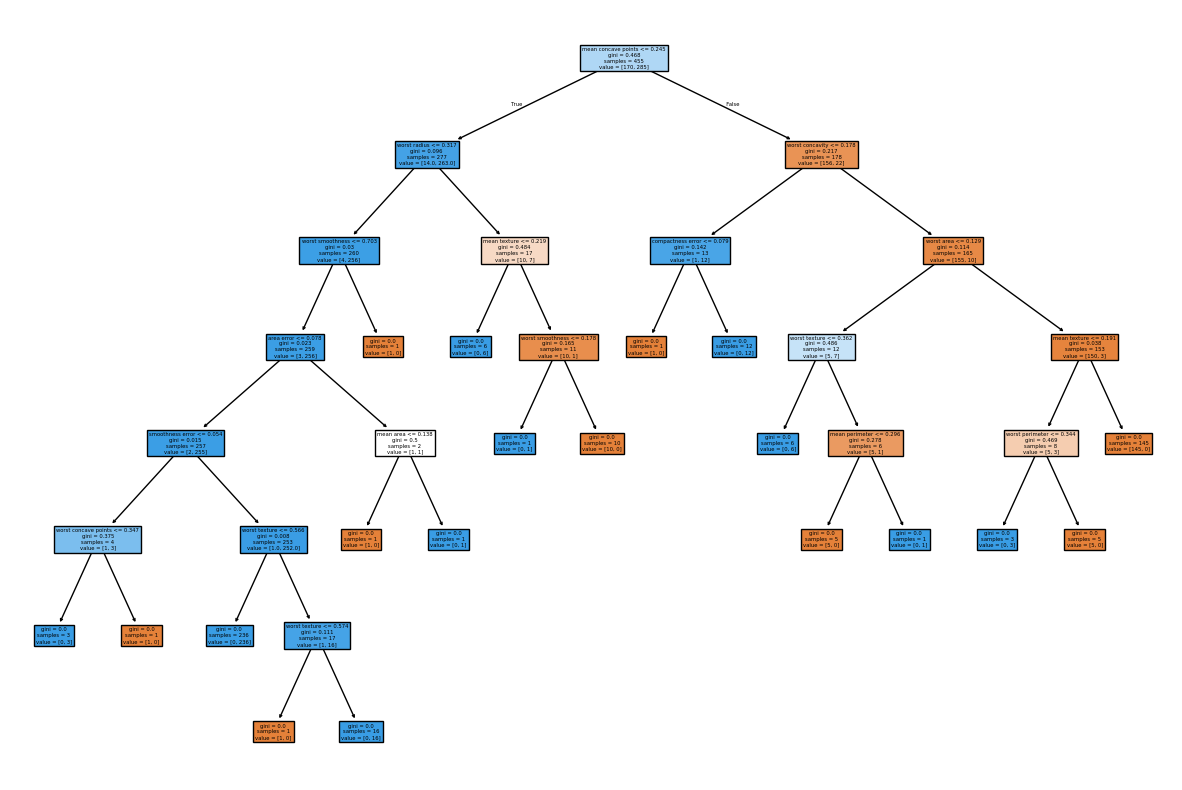

In [8]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

We can see it has built a fairly large tree ... maybe it has overfit? Perhaps regularisation will help ...

We can search our hyperparameters and see what would be best:

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# this is the list of parameters we will tune. Some are fixed values some are distributions
tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),  # Draw from a uniform distribution between 3 and 15
    'min_samples_split': randint(3, 9),  # Draw from a uniform distribution between 2 and 10
    'max_features': ['sqrt', 'log2', None]
}

# we will tune against f1_macro (to find the best choice)
score = 'f1_macro' # arbitrary choice

print(f"Tuning hyperparameters for {score}")
print("\n")

# do the search using 5 folds/chunks
clf = RandomizedSearchCV(DTC(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

# pass the data to fit/train
clf.fit(X_train, Y_train)

print("Best parameters set found on the training set:")
print(clf.best_params_)


Tuning hyperparameters for f1_macro


Best parameters set found on the training set:
{'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6}


Now we can train the model again, but using these hyperparameters:

In [10]:
DTC_algo = DTC(**clf.best_params_) # get the best parameters from grid search
DTC_model = DTC_algo.fit(X_train, Y_train)

And now we can predict again:

In [11]:
# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.92


Accuracy is better. However, we tuned for F1 macro ... maybe this will be better too:

Micro-averaged Precision: 0.92
Micro-averaged Recall: 0.92
Micro-averaged F1-score: 0.92


Macro-averaged Precision: 0.91
Macro-averaged Recall: 0.92
Macro-averaged F1-score: 0.92




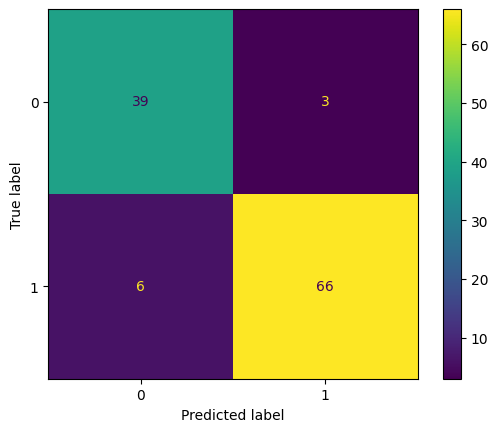

In [12]:
# create a confusion matrix
CM.from_predictions(Y_test, predict)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

F1 score is 3 points higher! Let's also check the tree:

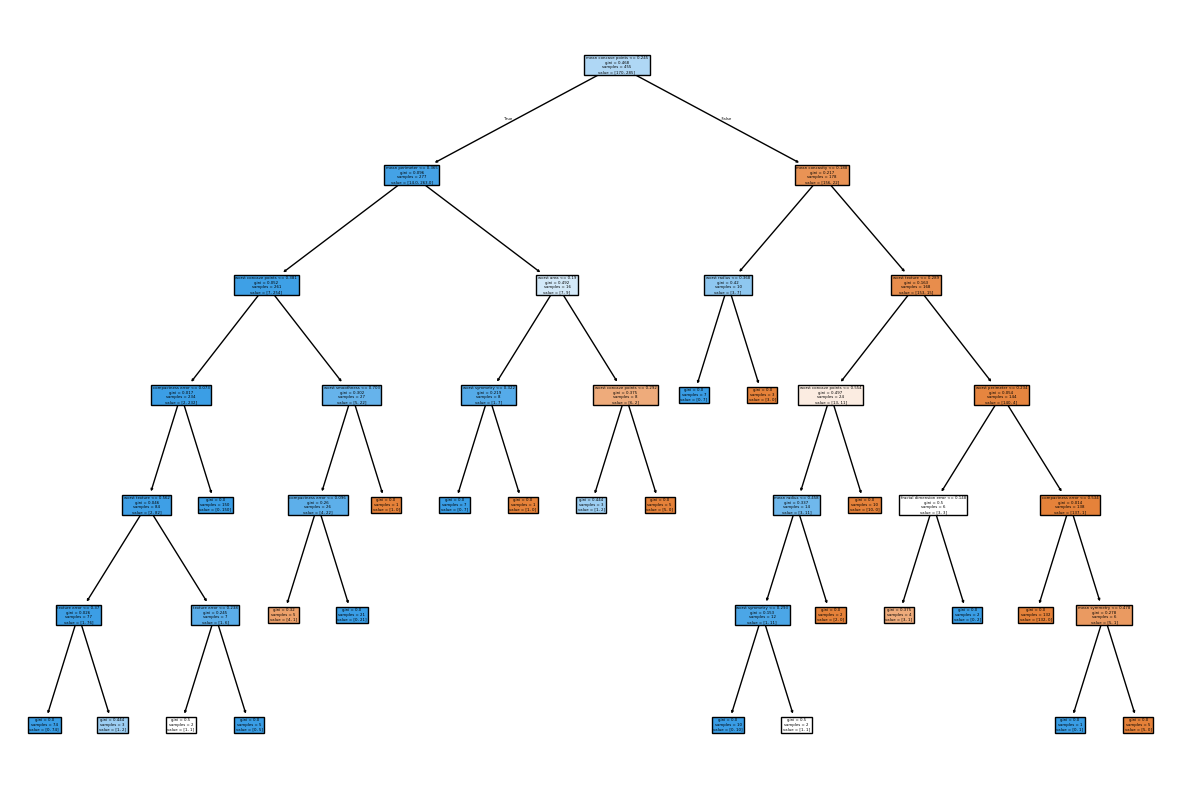

In [13]:
plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

A much smaller tree so likely to be less prone to overfitting!

### TASK
Given that this is a medical domain, possibly a better metric to optimise against would be _recall_. Reoptimise the model according to _macro recall_ and evaluate the results.





## Optimize with Recall Macro

### Subtask:
Re-run `RandomizedSearchCV` to find the best hyperparameters for the Decision Tree Classifier, but this time using 'recall_macro' as the scoring metric. The `tuned_parameters` will remain the same as in the previous optimization.


**Reasoning**:
The subtask requires re-running RandomizedSearchCV to optimize for 'recall_macro'. I will initialize RandomizedSearchCV with the specified scoring metric and fit it to the training data, then print the best parameters found.



In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.tree import DecisionTreeClassifier as DTC

# this is the list of parameters we will tune. Some are fixed values some are distributions
tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),  # Draw from a uniform distribution between 3 and 15
    'min_samples_split': randint(3, 9),  # Draw from a uniform distribution between 2 and 10
    'max_features': ['sqrt', 'log2', None]
}

# Set the scoring metric to 'recall_macro'
score = 'recall_macro'

print(f"Tuning hyperparameters for {score}")
print("\n")

# do the search using 5 folds/chunks
clf_recall = RandomizedSearchCV(DTC(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

# pass the data to fit/train
clf_recall.fit(X_train, Y_train)

print("Best parameters set found on the training set (optimised for recall_macro):")
print(clf_recall.best_params_)

Tuning hyperparameters for recall_macro


Best parameters set found on the training set (optimised for recall_macro):
{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_split': 7}


## Train Model with Best Recall Macro Parameters

### Subtask:
Train a new Decision Tree Classifier model using the `best_params_` found from the `RandomizedSearchCV` optimized for 'recall_macro'.

#### Instructions
1. Initialize a new `DecisionTreeClassifier` instance using `clf_recall.best_params_`.
2. Fit this new model to the training data (`X_train`, `Y_train`).
3. Store the fitted model in a variable, for example, `DTC_model_recall`.

**Reasoning**:
The next step is to train a new Decision Tree Classifier model using the best hyperparameters found by `RandomizedSearchCV` for `recall_macro`. This involves initializing the model with `clf_recall.best_params_` and then fitting it to the training data.



In [17]:
from sklearn.tree import DecisionTreeClassifier as DTC

# Initialize a new Decision Tree Classifier with the best parameters found by clf_recall
DTC_algo_recall = DTC(**clf_recall.best_params_)

# Fit this new model to the training data
DTC_model_recall = DTC_algo_recall.fit(X_train, Y_train)

print("Decision Tree Classifier model optimized for recall_macro has been trained.")

Decision Tree Classifier model optimized for recall_macro has been trained.


**Reasoning**:
Now that the model optimized for `recall_macro` is trained, the next step is to make predictions on the test dataset (`X_test`) to evaluate its performance. This will allow us to calculate various metrics like accuracy, precision, recall, and F1-score.



In [18]:
from sklearn.metrics import accuracy_score

# Predict the test data using the new model optimized for recall_macro
predict_recall = DTC_model_recall.predict(X_test)

# Separate the first five predictions and the first five real values in Y_test
print("First five predictions vs. real values (optimized for recall_macro):")
for i in range(5):
  print(f'Predicted: {round(predict_recall[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print(f'Accuracy (optimized for recall_macro): {round(accuracy_score(Y_test, predict_recall),2)}')


First five predictions vs. real values (optimized for recall_macro):
Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1


Accuracy (optimized for recall_macro): 0.95


**Reasoning**:
After making predictions, the next step is to evaluate the model's performance using standard classification metrics such as the confusion matrix, precision, recall, and F1-score. This will provide a comprehensive understanding of how well the model optimized for recall_macro performs.



Confusion Matrix (optimized for recall_macro):


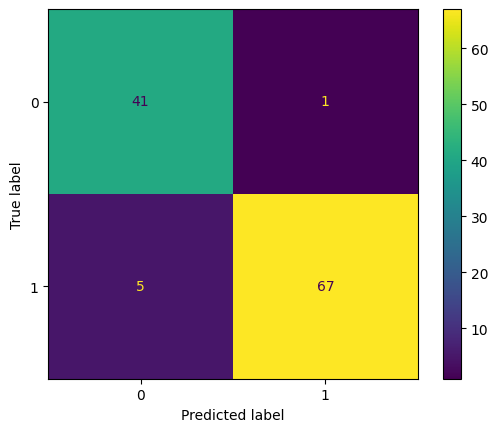

Micro-averaged Precision (optimized for recall_macro): 0.95
Micro-averaged Recall (optimized for recall_macro): 0.95
Micro-averaged F1-score (optimized for recall_macro): 0.95


Macro-averaged Precision (optimized for recall_macro): 0.94
Macro-averaged Recall (optimized for recall_macro): 0.95
Macro-averaged F1-score (optimized for recall_macro): 0.94


In [20]:
from sklearn.metrics import ConfusionMatrixDisplay as CM
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Create a confusion matrix
print("Confusion Matrix (optimized for recall_macro):")
CM.from_predictions(Y_test, predict_recall)
plt.show()

# Calculate precision, recall, and F1-score (micro-averaged)
precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(Y_test, predict_recall, average='micro')
print(f"Micro-averaged Precision (optimized for recall_macro): {round(precision_micro, 2)}")
print(f"Micro-averaged Recall (optimized for recall_macro): {round(recall_micro, 2)}")
print(f"Micro-averaged F1-score (optimized for recall_macro): {round(f1_score_micro, 2)}")
print("\n")

# Calculate precision, recall, and F1-score (macro-averaged)
precision_macro, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(Y_test, predict_recall, average='macro')
print(f"Macro-averaged Precision (optimized for recall_macro): {round(precision_macro, 2)}")
print(f"Macro-averaged Recall (optimized for recall_macro): {round(recall_macro, 2)}")
print(f"Macro-averaged F1-score (optimized for recall_macro): {round(f1_score_macro, 2)}")

## Visualize the Optimized Decision Tree
Visualize the new Decision Tree Classifier model (`DTC_model_recall`) that was optimized for 'recall_macro'.

#### Instructions
1. Use `plot_tree` from `sklearn.tree` to visualize the `DTC_model_recall`.
2. Ensure the plot is filled (`filled=True`) and feature names are displayed (`feature_names=X_train.columns`).
3. Set an appropriate figure size for better readability.
4. Display the plot using `plt.show()`.

**Reasoning**:
Following the evaluation of metrics, the next logical step is to visualize the decision tree to understand its structure, especially how it differs from the previous one, after being optimized for 'recall_macro'.



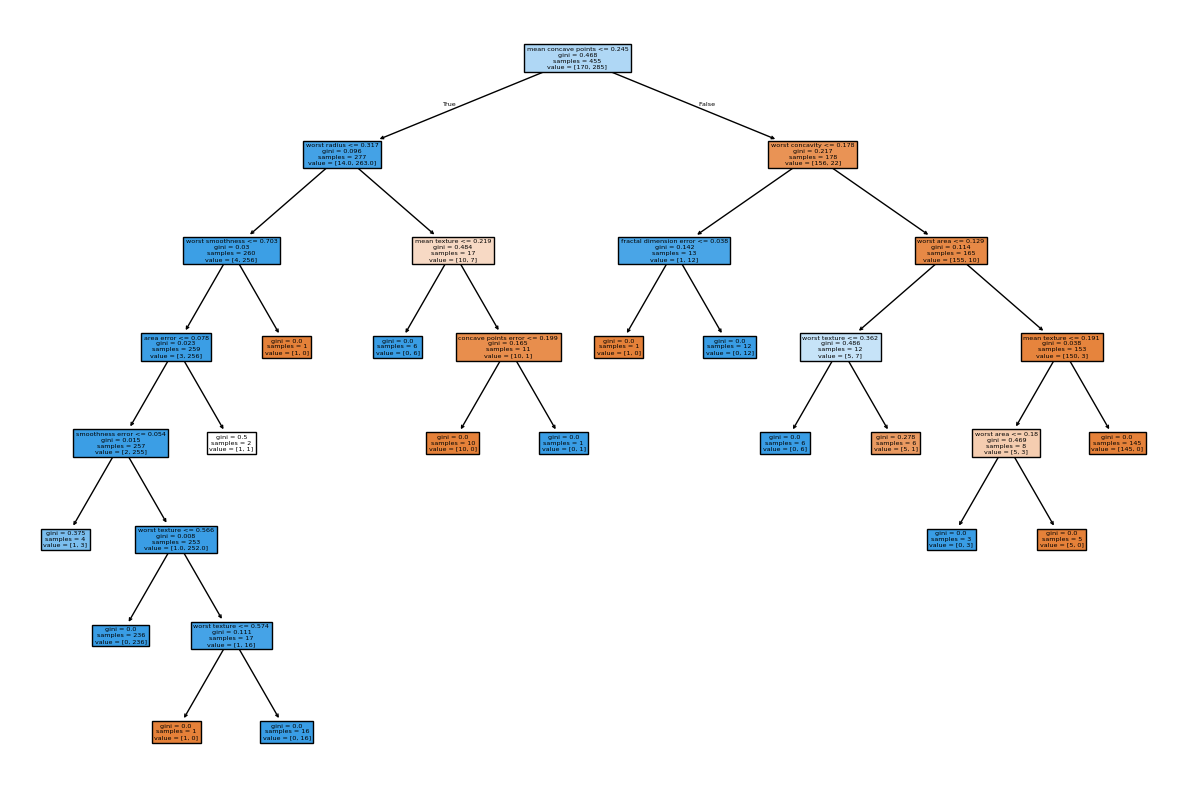

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plot_tree(DTC_model_recall, filled=True, feature_names=X_train.columns)
plt.show()

### Data Analysis Key Findings
*   **Optimal Hyperparameters for Recall Macro:** `RandomizedSearchCV` identified the best hyperparameters for optimizing 'recall_macro' as: `{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_split': 7}`.
*   **Improved Model Performance:** The new Decision Tree Classifier, optimized for 'recall_macro', achieved an accuracy of 0.95 on the test data.
*   **Detailed Metric Performance:**
    *   **Micro-averaged:** Precision: 0.95, Recall: 0.95, F1-score: 0.95.
    *   **Macro-averaged:** Precision: 0.94, Recall: 0.95, F1-score: 0.94.
*   **Significant Recall Enhancement:** The macro-averaged recall saw a notable increase from 0.92 (in the previously F1-macro optimized model) to 0.95 in this recall-macro optimized model, indicating a better ability to identify positive cases.
*   **Overall Performance Boost:** Optimizing for recall macro not only improved recall but also led to an uplift in other metrics, including accuracy, micro/macro precision, and F1-score, suggesting a more robust model.
*   **Compact Tree Structure:** The visualization of the decision tree showed a more compact structure, implying effective regularization and a generalized model.

